## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [60]:
df_ha = pd.read_csv('./Data/ha_1.csv')
df_ha.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [61]:
cat = ['sex', 'cp', 'restecg']

df_ha[cat] = df_ha[cat].astype('object')
df_ha.describe()

,age,trtbps,chol,thalach
count,204.000000,204.000000,204.000000,204.000000
mean,53.813725,131.245098,248.377451,149.147059
std,9.354781,18.352024,53.176624,23.990925
min,29.000000,94.000000,126.000000,71.000000
25%,46.000000,120.000000,212.750000,132.000000
50%,54.000000,129.500000,241.000000,153.500000
75%,61.000000,140.000000,276.250000,166.250000
max,77.000000,200.000000,564.000000,202.000000


In [62]:
df_ha['diagnosis'] = df_ha['diagnosis'].map({'Disease': 0, 'No Disease': 1})

X = df_ha[['age', 'chol']]
y = df_ha['diagnosis']

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [63]:
ct = ColumnTransformer(
    [("num", StandardScaler(), ['age', 'chol'])],
    remainder="drop"
)

pipeline_log = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())]
)

In [64]:
pipeline_log.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'chol'])])),
                ('log', LogisticRegression())])

In [65]:
scaler = StandardScaler()
scaler.fit(df_ha[['age', 'chol']])

means = scaler.mean_
stds = scaler.scale_

logistic_model = pipeline_log.named_steps['log']
scaled_coefficients = logistic_model.coef_[0]
scaled_intercept = logistic_model.intercept_[0]

coefficients = scaled_coefficients / stds
intercept = scaled_intercept - sum(means * scaled_coefficients / stds)

equation = f"logit(P(Disease)) = {intercept:.3f}"
for coef, feature in zip(coefficients, ['age', 'chol']):
    equation += f" + {coef:.3f}*{feature}"

print(equation)

logit(P(Disease)) = -3.185 + 0.046*age + 0.002*chol


In [66]:
logit = np.log(0.5/(1 - 0.5))
print((logit - intercept - coefficients[0] * 55) / coefficients[1])

logit = np.log(0.9/(1 - 0.9))
print((logit - intercept - coefficients[0] * 55) / coefficients[1])

367.9857241548498
1585.3659801948102


For a 55 year old, cholesterol needs to be 368 for the doctors to predict heart disease is present\
For a 55 year old, cholesterol needs to be 1585 for the doctors to estimate a 90% chance heart disease is present

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [67]:
pipeline_lda = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis())]
)

In [68]:
pipeline_lda.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'chol'])])),
                ('lda', LinearDiscriminantAnalysis())])

In [69]:
lda_model = pipeline_lda.named_steps['lda']
scaled_coefficients = lda_model.coef_[0]
scaled_intercept = lda_model.intercept_[0]

coefficients = scaled_coefficients / stds
intercept = scaled_intercept - sum(means * scaled_coefficients / stds)

equation = f"logit(P(Disease)) = {intercept:.3f}"
for coef, feature in zip(coefficients, ['age', 'chol']):
    equation += f" + {coef:.3f}*{feature}"

print(equation)

logit(P(Disease)) = -3.220 + 0.047*age + 0.002*chol


In [70]:
logit = np.log(0.5/(1 - 0.5))
print((logit - intercept - coefficients[0] * 55) / coefficients[1])

368.2353575299382


For a 55 year old, cholesterol needs to be 368 for the doctors to predict heart disease is present

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [71]:
pipeline_svc = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC(kernel="linear"))]
)

In [73]:
params = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
}
grid_search = GridSearchCV(pipeline_svc, params, cv = 5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'chol'])])),
                                       ('svc', SVC(kernel='linear'))]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10]},
             scoring='neg_mean_squared_error')

In [76]:
svc_model = grid_search.best_estimator_.named_steps['svc']
scaled_coefficients = svc_model.coef_[0]
scaled_intercept = svc_model.intercept_[0]

coefficients = scaled_coefficients / stds
intercept = scaled_intercept - sum(means * scaled_coefficients / stds)

equation = f"logit(P(Disease)) = {intercept:.3f}"
for coef, feature in zip(coefficients, ['age', 'chol']):
    equation += f" + {coef:.3f}*{feature}"

print(equation)

logit(P(Disease)) = -4.683 + 0.064*age + 0.004*chol


In [77]:
logit = np.log(0.5/(1 - 0.5))
print((logit - intercept - coefficients[0] * 55) / coefficients[1])

312.75313016443647


For a 55 year old, cholesterol needs to be 313 for the doctors to predict heart disease is present

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

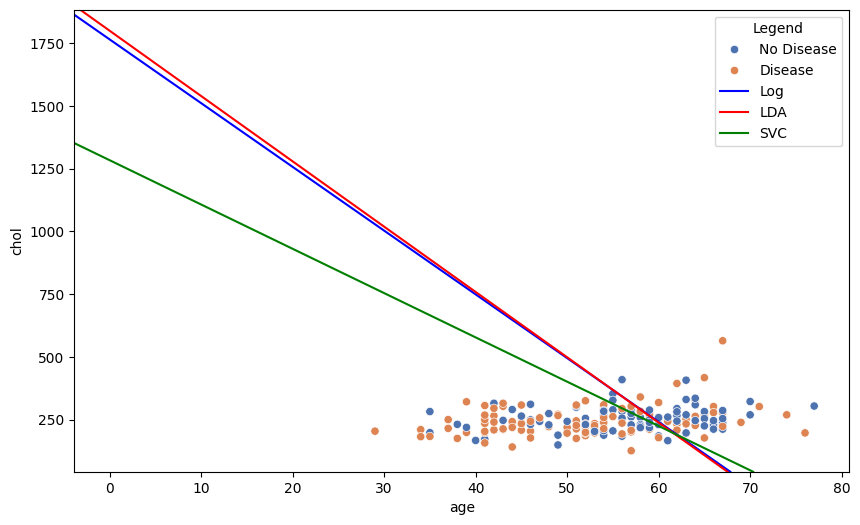

In [91]:
scaled_coefficients = pipeline_log.named_steps['log'].coef_[0]
scaled_intercept = pipeline_log.named_steps['log'].intercept_[0]
coef_log = scaled_coefficients / stds
int_log = scaled_intercept - sum(means * scaled_coefficients / stds)

scaled_coefficients = pipeline_lda.named_steps['lda'].coef_[0]
scaled_intercept = pipeline_lda.named_steps['lda'].intercept_[0]
coef_lda = scaled_coefficients / stds
int_lda = scaled_intercept - sum(means * scaled_coefficients / stds)

scaled_coefficients = svc_model.coef_[0]
scaled_intercept = svc_model.intercept_[0]
coef_svc = scaled_coefficients / stds
int_svc = scaled_intercept - sum(means * scaled_coefficients / stds)

diagnosis_labels = {0: "Disease", 1: "No Disease"}

# Creating the scatter plot with custom labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ha, x='age', y='chol', hue='diagnosis', palette='deep', hue_order=[1, 0], legend='full')

plt.axline(xy1=(0, -int_log / coef_log[1]), slope=-coef_log[0] / coef_log[1], color='blue', label='Log')
plt.axline(xy1=(0, -int_lda / coef_lda[1]), slope=-coef_lda[0] / coef_lda[1], color='red', label='LDA')
plt.axline(xy1=(0, -int_svc / coef_svc[1]), slope=-coef_svc[0] / coef_svc[1], color='green', label='SVC')

handles, labels = plt.gca().get_legend_handles_labels()
updated_labels = [diagnosis_labels[int(label)] if label in ['0', '1'] else label for label in labels]

plt.legend(handles, updated_labels, title='Legend', loc='best')
plt.show()